# Gravitational Orbits using Lagrange's equation

Defines a GravitationalOrbits class that is used to generate basic orbit plots from solving Lagrange's equations. This notebook answers parts a, b and d of the problem.

* Last revised 29-April-2022 by Kathy Duray (duray.5@osu.edu).

We have gravitational attraction between 2 bodies, which are defined by their x and y coordinates in space. The distance between these bodies is:
$$\begin{align}
    r_{12} &= \sqrt{(x_1 - x_2)^2 + (y_1 + y_2)^2}
\end{align}$$

To plot our graphs, we need the velocties and the forces. The forces for each body in each direction are 
$$\begin{align}
    F_{x1} &= \frac{G m_1 (x_2 - x_1)}{r_{12}} \;, & F_{y1} &= \frac{G m_1 (y_2 - y_1)}{r_{12}} \\
    F_{x2} &= \frac{G m_2 (x_2 - x_1)}{r_{12}} \;, & F_{y2} &= \frac{G m_2 (y_2 - y_1)}{r_{12}}
\end{align}$$

So the function **dz_dt** will return $\dot{x}_1, F_{x1}, \dot{y}_1, F_{y1}, \dot{x}_2, F_{x2}, \dot{x}_2, F_{y2}$

We will also make a comparison between the conservation of energy of the Leapfrog method versus SciPy ODE. The energy is defined as
$$\begin{align}
    E &= \frac{1}{2} (m_1 + m_2) \dot{\vec{R}} + \frac{1}{2} \mu \dot{\vec{r}} - \frac{G m_1 m_2}{r_{12}^2}
\end{align}$$

We will work in an inertial frame with the origin at $\dot{\vec{R}}$ such that $\dot{\vec{R}} = 0$

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Image

In [2]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# Part a) GravitationalOrbits class and Utility Functions

In [3]:
class GravitationalOrbits():
    """
    This class implements the parameters and the Langrange equations 
    for two particles orbiting around each other under gravity
    
    Parameters
    ----------
    m_1: float
    m_2: float
    G: float
    
    Methods
    -------
    dz_dt(t, z)
        Returns the right side of the differential equation in
        vector z, given time t and the corresponding value of z.
    """
    
    def __init__(self, m_1=1., m_2=1., G=1., ang_mom=1., n=1., k=1, mu=1):
        self.m_1 = m_1
        self.m_2 = m_2
        self.G = G
        self.ang_mom = ang_mom
        self.n = n
        self.k = k
        self.mu = mu
        
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        z : float
            8-component vector with:
                z[0] = x_1(t) and z[1] = x_dot_1(t)
                z[2] = y_1(t) and z[3] = y_dot_1(t)
                z[4] = x_2(t) and z[5] = x_dot_2(t)
                z[6] = y_2(t) and z[7] = y_dot_2(t)
            
        """
        
        r_12 = np.sqrt( (z[0] - z[4])**2 + (z[2] - z[6])**2 )
        
        return [z[1], self.G * self.m_2 * (z[4] - z[0]) / r_12**3,  \
                z[3], self.G * self.m_2 * (z[6] - z[2]) / r_12**3,  \
                z[5], -self.G * self.m_1 * (z[4] - z[0]) / r_12**3, \
                z[7], -self.G * self.m_1 * (z[6] - z[2]) / r_12**3  ]
    
    def energy(self, t_pts, z):
        """Evaluate the energy as a function of time"""
        
        # the reduced mass
        mu = (self.m_1 * self.m_2)/(self.m_1 + self.m_2)
        
        # the kinetic energy in an inertial frame
        KE = (1/2)*mu*( (x_dot_1 - x_dot_2)**2 + (y_dot_1 - y_dot_2)**2 )
        
        # the gravitational potential energy
        V = -self.G * self.m_1 * self.m_2 / ((x_1 - x_2) + (y_1 - y_2))
        
        return KE + V
    
    def solve_ode(self, t_pts, z_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method='RK23', 
                             atol=abserr, rtol=relerr)
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y
        
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
   
    def solve_ode_Leapfrog(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0 = z_0
        
        # initialize the time and all the coordinate arrays with zeros
        num_t_pts = len(t_pts)
        
        x_1 = np.zeros(num_t_pts)
        x_dot_1 = np.zeros(num_t_pts)
        x_dot_1_half = np.zeros(num_t_pts)
        
        y_1 = np.zeros(num_t_pts)
        y_dot_1 = np.zeros(num_t_pts)
        y_dot_1_half = np.zeros(num_t_pts)
        
        x_2 = np.zeros(num_t_pts)
        x_dot_2 = np.zeros(num_t_pts)
        x_dot_2_half = np.zeros(num_t_pts)
        
        y_2 = np.zeros(num_t_pts)
        y_dot_2 = np.zeros(num_t_pts)
        y_dot_2_half = np.zeros(num_t_pts)
        
        # initial conditions
        x_1[0] = x_1_0
        x_dot_1[0] = x_dot_1_0
            
        y_1[0] = y_1_0
        y_dot_1[0] = y_dot_1_0
        
        x_2[0] = x_2_0
        x_dot_2[0] = x_dot_2_0
            
        y_2[0] = y_2_0
        y_dot_2[0] = y_dot_2_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z = [x_1[i], x_dot_1[i], y_1[i], y_dot_1[i], x_2[i], x_dot_2[i], y_2[i], y_dot_2[i]  ]
            
            x_dot_1_half[i] = x_dot_1[i] + self.dz_dt(t, z)[1] * delta_t/2.
            x_1[i+1] = x_1[i] + x_dot_1_half[i] * delta_t
            
            y_dot_1_half[i] = y_dot_1[i] + self.dz_dt(t, z)[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_dot_1_half[i] * delta_t
            
            x_dot_2_half[i] = x_dot_2[i] + self.dz_dt(t, z)[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_dot_2_half[i] * delta_t
            
            y_dot_2_half[i] = y_dot_2[i] + self.dz_dt(t, z)[7] * delta_t/2.
            y_2[i+1] = y_2[i] + y_dot_2_half[i] * delta_t
            
            z = [x_1[i+1], x_dot_1[i], y_1[i+1], y_dot_1[i], x_2[i+1], x_dot_2[i], y_2[i+1], y_dot_2[i]  ]
            x_dot_1[i+1] = x_dot_1_half[i] + self.dz_dt(t, z)[1] * delta_t/2.
            y_dot_1[i+1] = y_dot_1_half[i] + self.dz_dt(t, z)[3] * delta_t/2.
            x_dot_2[i+1] = x_dot_2_half[i] + self.dz_dt(t, z)[5] * delta_t/2.
            y_dot_2[i+1] = y_dot_2_half[i] + self.dz_dt(t, z)[7] * delta_t/2.
            
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Part b) Orbit plots to prove the given condition 

In [6]:
# Pick times to plot over (generate the full time then use slices)
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Initial conditions for masses and G
G = 1.
m_1 = 1.
m_2 = 10.

# Time to initiate our gravitiational orbits!!!
o1 = GravitationalOrbits(m_1, m_2, G)

# Initial conditions when the center of mass velocity is zero
x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

<IPython.core.display.Javascript object>


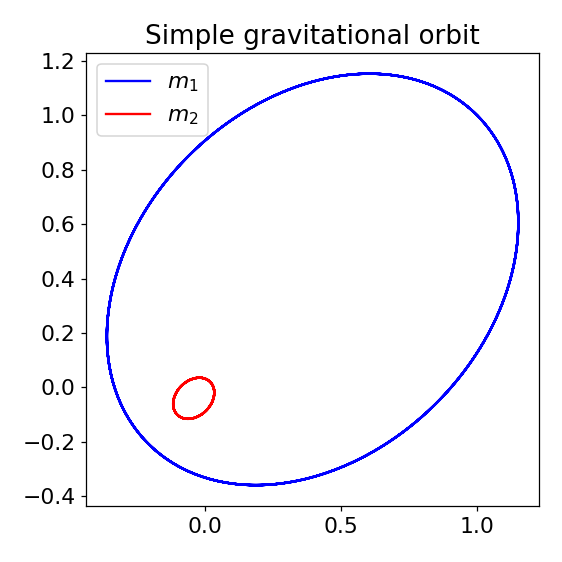

In [7]:
# labels for the axis
orbit_labels = (r'$x$', r'$y$')

#start plotting
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

<IPython.core.display.Javascript object>


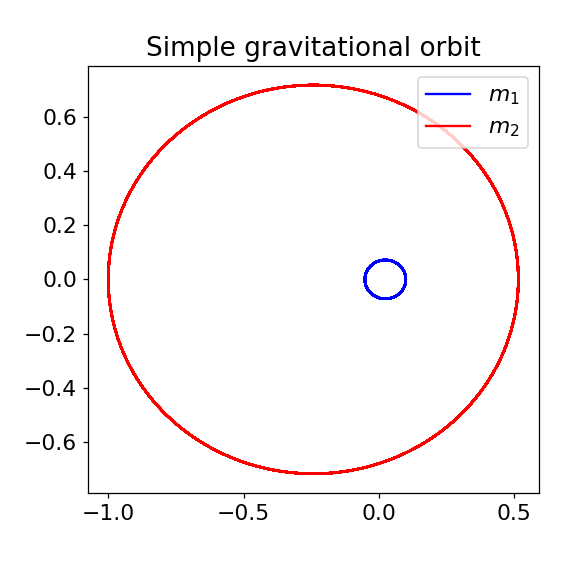

In [8]:
#Common plotting time
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

G = 10.
m_1 = 10.
m_2 = 1.

# Time to initiate our gravitiational orbits!!! (again for the new conditions)
o1 = GravitationalOrbits(m_1, m_2, G)

#Inital conditions
x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., 0.75
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

#Start plotting
fig = plt.figure(figsize=(5,5))

#orbit plot
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

## Part d) Using the Leapfrog method

I will use the same conditions as above, but I will instead call the Leapfrog function to solve the differential equation

In [9]:
# Pick times to plot over (generate the full time then use slices)
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Initial conditions for masses and G
G = 1.
m_1 = 1.
m_2 = 10.

# Time to initiate our gravitiational orbits!!!
o1 = GravitationalOrbits(m_1, m_2, G)

# Initial conditions when the center of mass velocity is zero
x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode_Leapfrog(t_pts, z_0)

<IPython.core.display.Javascript object>


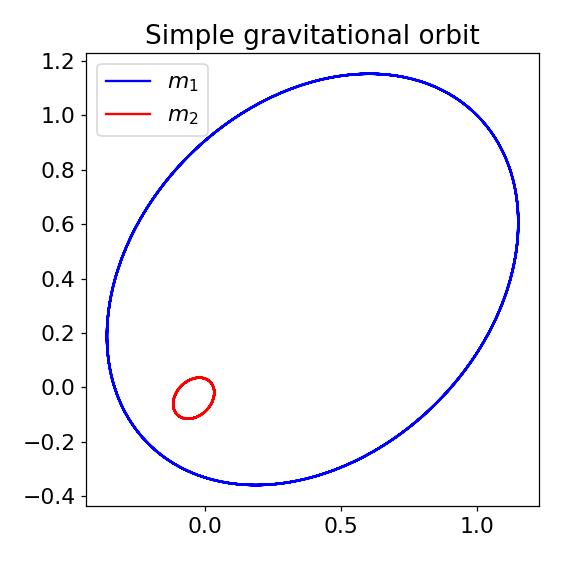

In [10]:
# labels for the axis
orbit_labels = (r'$x$', r'$y$')

#start plotting
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

<IPython.core.display.Javascript object>


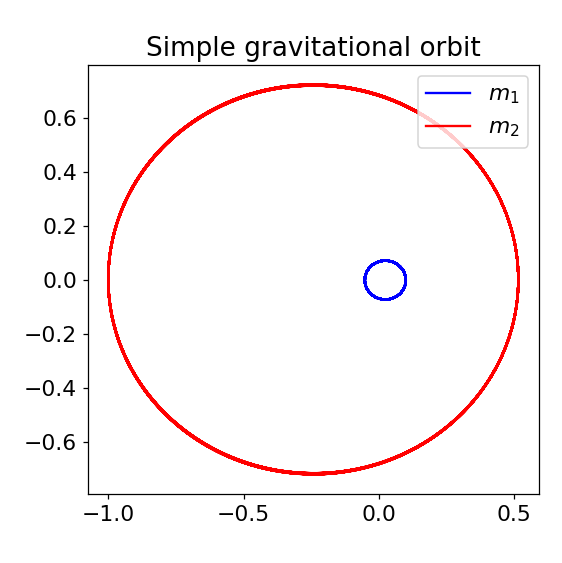

In [11]:
#Common plotting time
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

G = 10.
m_1 = 10.
m_2 = 1.

# Time to initiate our gravitiational orbits!!! (again for the new conditions)
o1 = GravitationalOrbits(m_1, m_2, G)

#Inital conditions
x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., 0.75
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode_Leapfrog(t_pts, z_0)

#Start plotting
fig = plt.figure(figsize=(5,5))

#orbit plot
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

I will now plot the energy conservation to prove that energy is not lost over time when using the Leapfrog method. 

In [15]:
# Plotting time (and being careful to make it match the energy length)
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# setting initial conditions
z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
z_pts = o1.solve_ode(t_pts, z_0)
z_pts_LF = o1.solve_ode_Leapfrog(t_pts, z_0)

In [16]:
E_tot_pts = o1.energy(t_pts, z_pts)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = o1.energy(t_pts, z_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

<IPython.core.display.Javascript object>


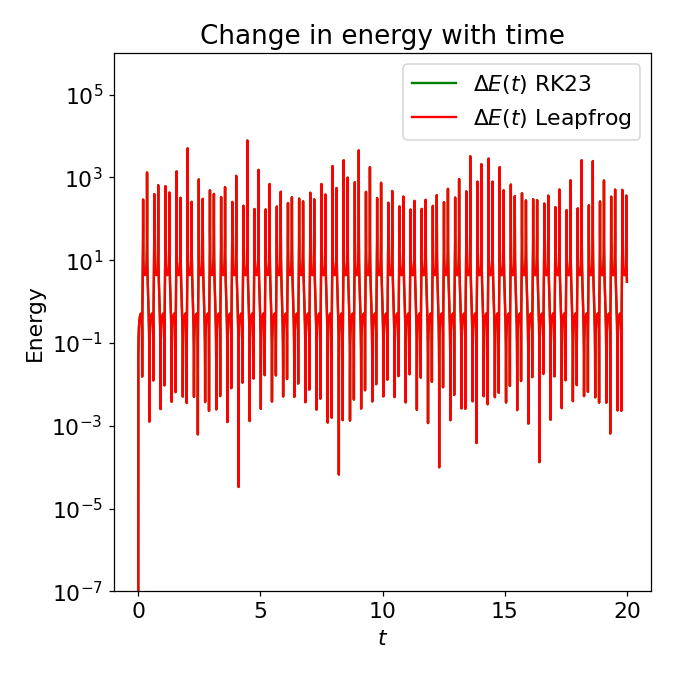

In [17]:
fig_energy = plt.figure(figsize=(6,6))

ax_energya = fig_energy.add_subplot(1,1,1)

ax_energya.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_energya.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_energya.set_ylim(1.e-7, 1.e6)
ax_energya.set_xlabel(r'$t$')
ax_energya.set_ylabel(r'Energy')
ax_energya.set_title('Change in energy with time')
ax_energya.legend()

fig_energy.tight_layout()